In [4]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image
import os

In [5]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

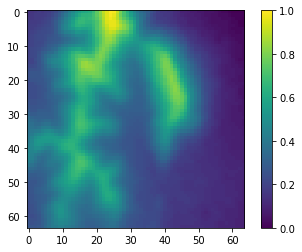

In [7]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[1].view(64, 64))
plt.colorbar(p)
plt.show()

In [23]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
def double_cnn(in_n, out_n):
    return nn.Conv2d(in_n, out_n, kernel_size=3, padding=1)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 64)
        self.enc_linear_1_2 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        out = F.leaky_relu(self.dec_linear_1(z))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [46]:
vae = VAE().cuda()

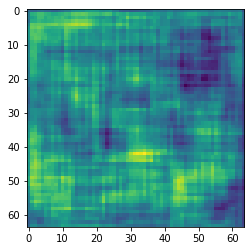

In [47]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [48]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD *= 0.1
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.001)

vae.train()
epochs = 100

for epoch in range(epochs):
    for i, data in enumerate(dataloader):
        data_size = data.shape[0]
        optimizer.zero_grad()
        data = data.cuda()
        out, mu, logvar = vae(data)
        loss, MSE, KLD = loss_function(out, data, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
                  loss.item() / data_size, MSE.item() / data_size, KLD.item() / data_size)
            print(msg)

epoch[1/100], loss=238.352, MSE=238.350, KLD=0.002
epoch[1/100], loss=48.554, MSE=41.625, KLD=6.929
epoch[1/100], loss=40.447, MSE=33.196, KLD=7.251
epoch[1/100], loss=35.139, MSE=27.615, KLD=7.524
epoch[1/100], loss=31.767, MSE=24.582, KLD=7.186
epoch[1/100], loss=31.973, MSE=25.142, KLD=6.830
epoch[2/100], loss=27.390, MSE=20.939, KLD=6.451
epoch[2/100], loss=25.090, MSE=18.565, KLD=6.526
epoch[2/100], loss=27.895, MSE=21.347, KLD=6.548
epoch[2/100], loss=23.468, MSE=17.078, KLD=6.390
epoch[2/100], loss=23.514, MSE=17.201, KLD=6.313
epoch[2/100], loss=23.024, MSE=16.682, KLD=6.341
epoch[3/100], loss=24.399, MSE=18.284, KLD=6.115
epoch[3/100], loss=25.321, MSE=18.817, KLD=6.504
epoch[3/100], loss=22.044, MSE=15.788, KLD=6.256
epoch[3/100], loss=22.142, MSE=15.849, KLD=6.293
epoch[3/100], loss=21.694, MSE=15.265, KLD=6.430
epoch[3/100], loss=21.181, MSE=14.834, KLD=6.346
epoch[4/100], loss=25.664, MSE=19.671, KLD=5.994
epoch[4/100], loss=20.342, MSE=14.216, KLD=6.126
epoch[4/100], loss

epoch[28/100], loss=15.589, MSE=9.113, KLD=6.476
epoch[28/100], loss=16.479, MSE=9.945, KLD=6.533
epoch[29/100], loss=16.964, MSE=10.087, KLD=6.877
epoch[29/100], loss=17.683, MSE=10.673, KLD=7.010
epoch[29/100], loss=17.222, MSE=10.696, KLD=6.526
epoch[29/100], loss=16.945, MSE=10.146, KLD=6.798
epoch[29/100], loss=17.056, MSE=10.113, KLD=6.944
epoch[29/100], loss=15.882, MSE=9.361, KLD=6.521
epoch[30/100], loss=18.335, MSE=11.547, KLD=6.788
epoch[30/100], loss=15.935, MSE=9.259, KLD=6.675
epoch[30/100], loss=16.624, MSE=9.794, KLD=6.830
epoch[30/100], loss=17.174, MSE=10.530, KLD=6.644
epoch[30/100], loss=16.115, MSE=9.547, KLD=6.568
epoch[30/100], loss=16.711, MSE=10.098, KLD=6.613
epoch[31/100], loss=16.727, MSE=10.023, KLD=6.704
epoch[31/100], loss=18.677, MSE=11.633, KLD=7.044
epoch[31/100], loss=17.137, MSE=10.460, KLD=6.677
epoch[31/100], loss=18.284, MSE=11.515, KLD=6.770
epoch[31/100], loss=16.045, MSE=9.543, KLD=6.501
epoch[31/100], loss=16.701, MSE=10.045, KLD=6.656
epoch[3

epoch[56/100], loss=16.502, MSE=9.763, KLD=6.738
epoch[56/100], loss=17.817, MSE=11.054, KLD=6.762
epoch[56/100], loss=16.960, MSE=10.208, KLD=6.752
epoch[56/100], loss=16.156, MSE=9.467, KLD=6.689
epoch[57/100], loss=16.692, MSE=9.897, KLD=6.796
epoch[57/100], loss=15.912, MSE=9.168, KLD=6.744
epoch[57/100], loss=15.722, MSE=9.000, KLD=6.722
epoch[57/100], loss=16.524, MSE=9.911, KLD=6.613
epoch[57/100], loss=16.299, MSE=9.652, KLD=6.647
epoch[57/100], loss=16.775, MSE=9.940, KLD=6.835
epoch[58/100], loss=16.578, MSE=9.643, KLD=6.935
epoch[58/100], loss=16.630, MSE=9.642, KLD=6.988
epoch[58/100], loss=17.019, MSE=9.955, KLD=7.064
epoch[58/100], loss=16.296, MSE=9.612, KLD=6.684
epoch[58/100], loss=16.738, MSE=9.764, KLD=6.974
epoch[58/100], loss=16.739, MSE=9.641, KLD=7.097
epoch[59/100], loss=17.128, MSE=9.983, KLD=7.145
epoch[59/100], loss=16.428, MSE=9.687, KLD=6.741
epoch[59/100], loss=15.988, MSE=9.479, KLD=6.509
epoch[59/100], loss=17.250, MSE=10.075, KLD=7.175
epoch[59/100], lo

epoch[84/100], loss=16.810, MSE=10.242, KLD=6.568
epoch[84/100], loss=15.716, MSE=9.052, KLD=6.664
epoch[84/100], loss=16.937, MSE=10.089, KLD=6.848
epoch[84/100], loss=16.777, MSE=9.740, KLD=7.038
epoch[84/100], loss=15.276, MSE=8.629, KLD=6.647
epoch[85/100], loss=16.671, MSE=9.829, KLD=6.842
epoch[85/100], loss=15.173, MSE=8.566, KLD=6.607
epoch[85/100], loss=16.693, MSE=9.901, KLD=6.793
epoch[85/100], loss=16.584, MSE=9.549, KLD=7.035
epoch[85/100], loss=16.709, MSE=9.876, KLD=6.833
epoch[85/100], loss=15.688, MSE=9.022, KLD=6.666
epoch[86/100], loss=16.974, MSE=9.821, KLD=7.154
epoch[86/100], loss=17.527, MSE=10.656, KLD=6.871
epoch[86/100], loss=16.997, MSE=10.057, KLD=6.941
epoch[86/100], loss=16.020, MSE=9.544, KLD=6.476
epoch[86/100], loss=15.273, MSE=8.422, KLD=6.851
epoch[86/100], loss=16.103, MSE=9.482, KLD=6.621
epoch[87/100], loss=15.758, MSE=9.178, KLD=6.580
epoch[87/100], loss=15.532, MSE=9.023, KLD=6.509
epoch[87/100], loss=18.003, MSE=10.857, KLD=7.146
epoch[87/100], 

In [49]:
torch.cuda.empty_cache()

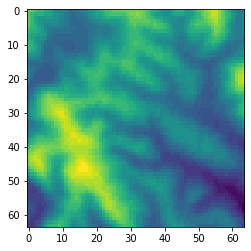

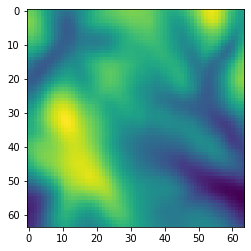

In [52]:
x = dataset[1367].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [9481]:
#torch.save(vae.state_dict(), './vae_save')

In [83]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

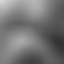

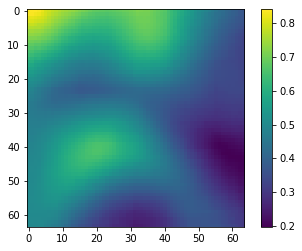

In [45]:
# Generator
code = torch.FloatTensor(1, 64).normal_()
out = vae.decode(code.cuda())
display(transforms.ToPILImage()(out.view(64, 64).cpu()))
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()